В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [2]:
!pip install opendatasets --upgrade --quiet

In [23]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score

import joblib

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data')
train_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv')

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


Area under ROC score on Train dataset: 86.26%
Train F1 Score: 0.5888


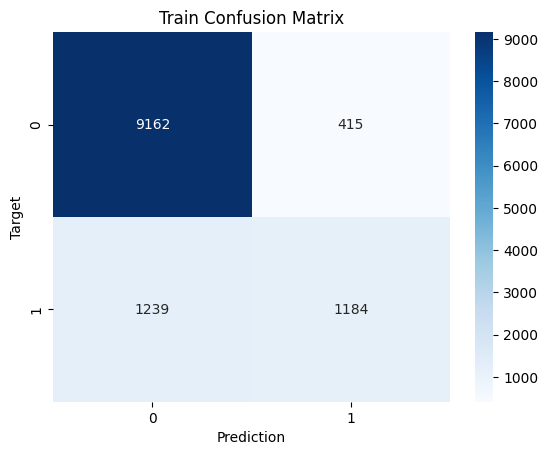

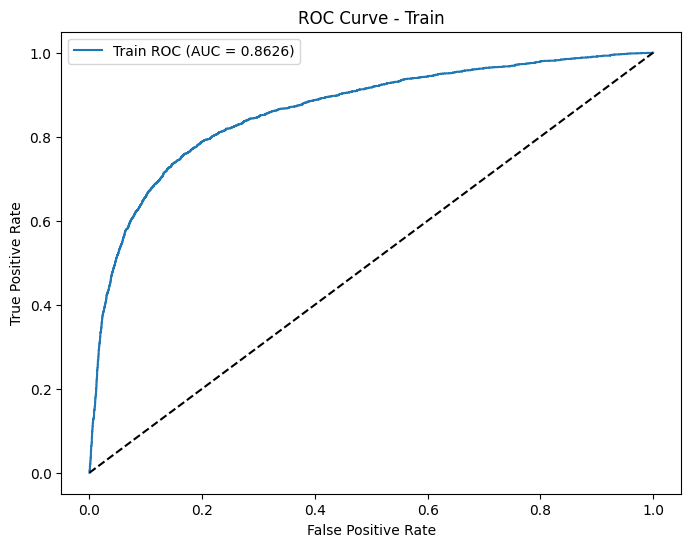

Area under ROC score on Validation dataset: 86.09%
Validation F1 Score: 0.5673


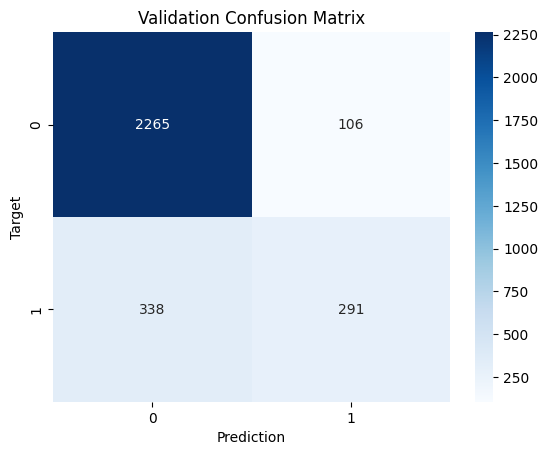

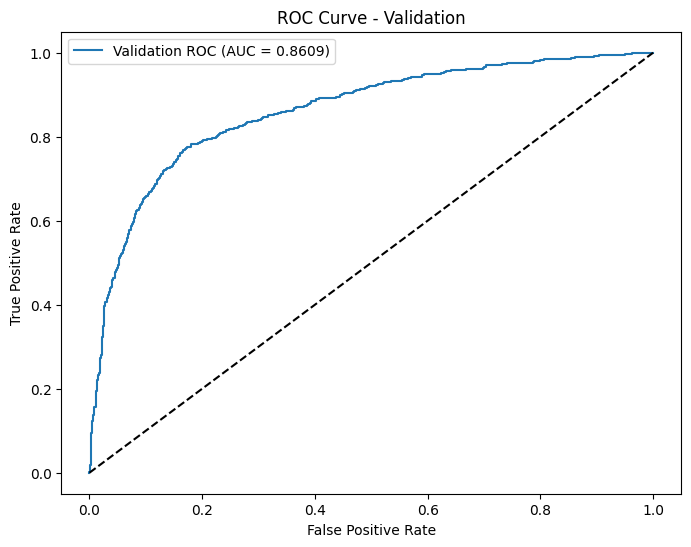

['./log_reg.joblib']

In [16]:
train_df = train_df.drop(columns=['id', 'CustomerId', 'Surname'])

train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender'], drop_first=True)

input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
target_col = 'Exited'

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    train_df[input_cols], train_df[target_col], test_size=0.2, random_state=42
)

numeric_cols = [col for col in train_inputs.columns if train_inputs[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in train_inputs.columns if train_inputs[col].dtype == 'object']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model_pipeline.fit(train_inputs, train_targets)

def predict_and_plot(model_pipeline, inputs, targets, name=''):
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    preds = (probs >= 0.5).astype(int)

    confusion_matrix_ = confusion_matrix(targets, preds)
    roc_auc = roc_auc_score(targets, probs)
    f1 = f1_score(targets, preds)

    print(f"Area under ROC score on {name} dataset: {roc_auc*100:.2f}%")
    print(f"{name} F1 Score: {f1:.4f}")

    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(targets, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{name} ROC (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

    return preds


train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds   = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

save_path = "./log_reg.joblib"
joblib.dump(model_pipeline, save_path)



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

=== Результаты модели с PolynomialFeatures ===
Area under ROC score on Train dataset: 92.01%
Train F1 Score: 0.7032


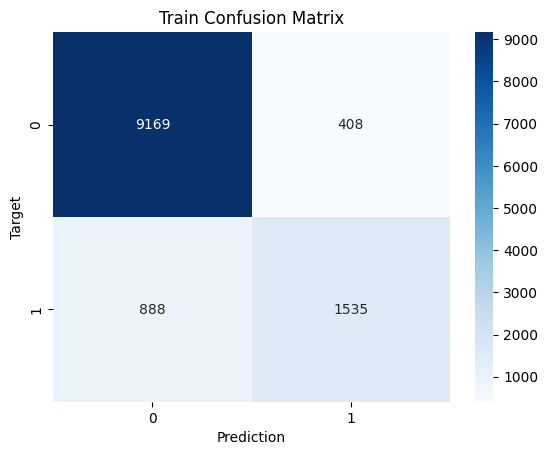

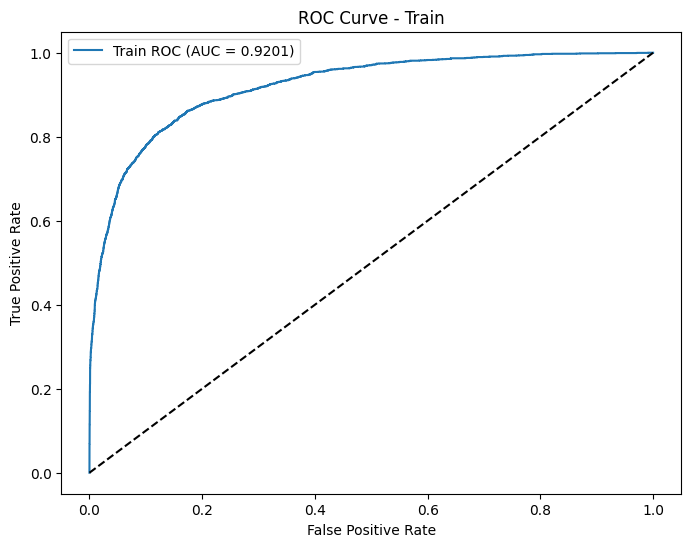

Area under ROC score on Validation dataset: 90.56%
Validation F1 Score: 0.6737


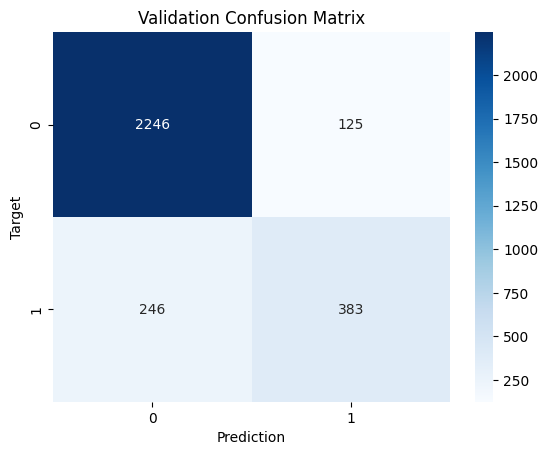

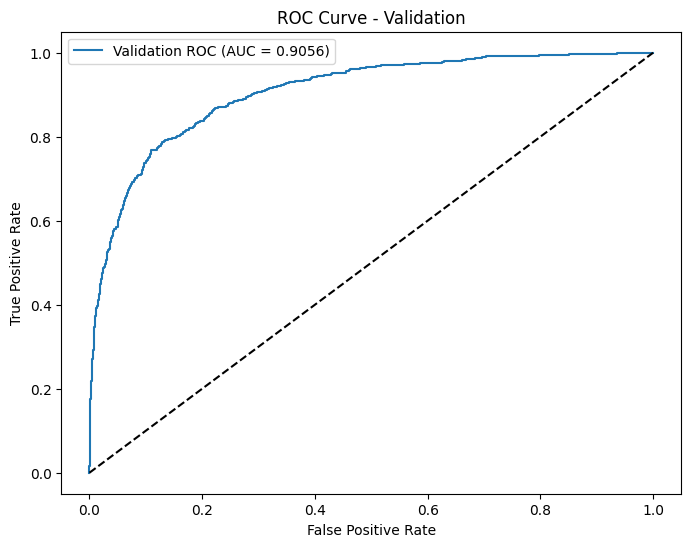

['./log_reg_poly.joblib']

In [19]:
numeric_transformer_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor_poly = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model_pipeline_poly.fit(train_inputs, train_targets)

print("=== Результаты модели с PolynomialFeatures ===")
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train')
val_preds_poly   = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation')

save_path_poly = "./log_reg_poly.joblib"
joblib.dump(model_pipeline_poly, save_path_poly)

**Висновки**

Модель демонструє високі показники AUC і F1 як на тренувальній, так і на валідаційній вибірках, що свідчить про непогану здатність до узагальнення. Незначне зниження результатів на валідації вказує, що сильного переобчислення не відбулося.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

=== PolynomialFeatures (4) ===
Area under ROC score on Train dataset: 93.10%
Train F1 Score: 0.7229


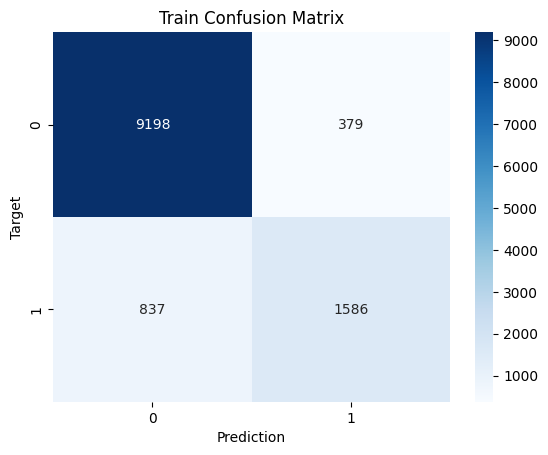

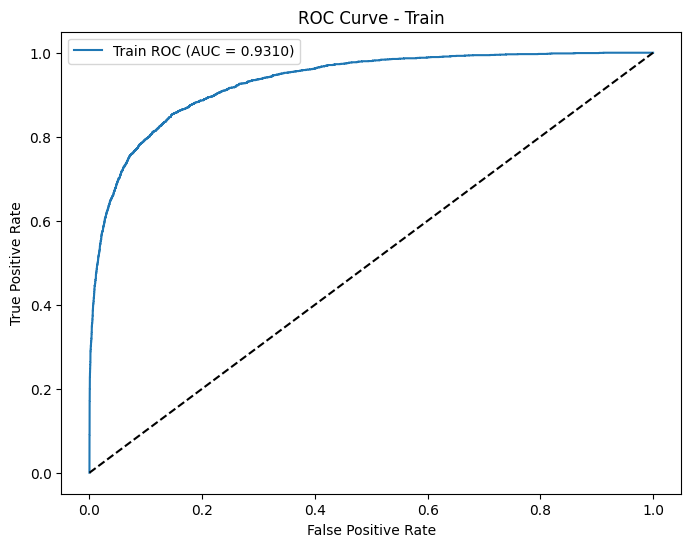

Area under ROC score on Validation dataset: 90.72%
Validation F1 Score: 0.6744


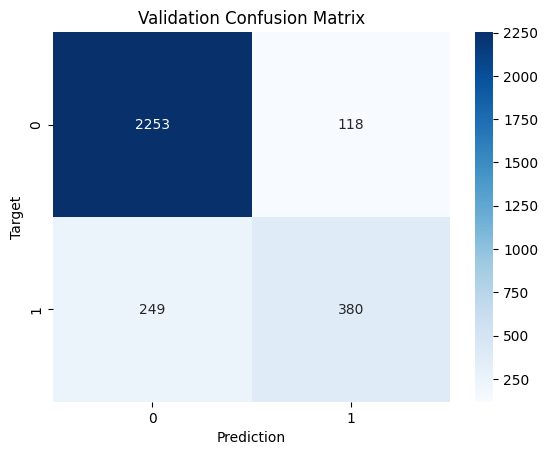

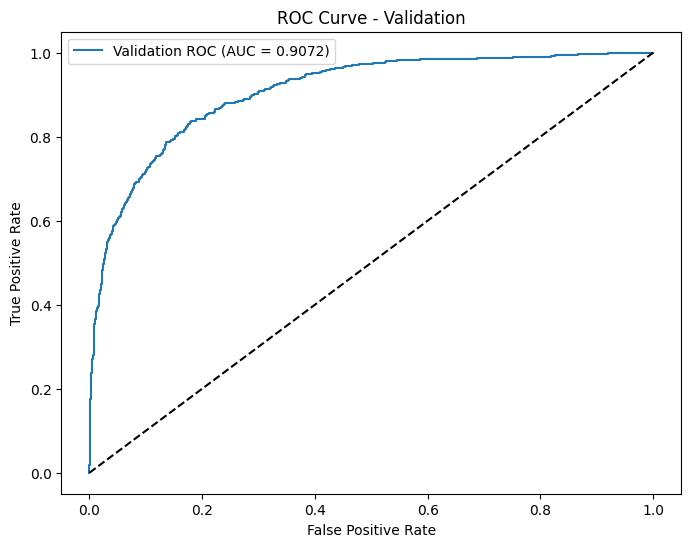

In [25]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor_poly4 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly4, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model_pipeline_poly4.fit(train_inputs, train_targets)

print("=== PolynomialFeatures (4) ===")
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name='Train')
val_preds_poly4   = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name='Validation')


**Висновки**

Модель із поліноміальними ознаками четвертого ступеня показує ще трохи кращі результати на трені (AUC 93%, F1 0.72). Валідаційний AUC теж високий (90.72%), тож невелике переобчислення все-таки є, але воно не критичне й модель загалом добре працює


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [26]:
df = pd.read_csv("regression_data.csv")

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

preprocessor = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())
])

model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

model_pipeline.fit(X_train, y_train)

y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=== TRAIN ===")
print(f"MSE: {train_mse:.4f}")
print(f"R^2: {train_r2:.4f}")

print("\n=== TEST ===")
print(f"MSE: {test_mse:.4f}")
print(f"R^2: {test_r2:.4f}")

=== TRAIN ===
MSE: 0.0000
R^2: 1.0000

=== TEST ===
MSE: 160.6987
R^2: 0.9311


**Висновки**

На тренувальному наборі модель буквально запам’ятала всі дані (R²=1 та MSE=0), тож там ідеальна точність. На тесті ж у нас MSE=160.70 і R²=0.93, що все ще дуже непогано, але свідчить про певне перенавчання через занадто велику гнучкість моделі.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [29]:
df = pd.read_csv("regression_data.csv")

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
preprocessing_only = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),
    ('scaler', StandardScaler())
])

X_train_poly = preprocessing_only.fit_transform(X_train)
X_test_poly = preprocessing_only.transform(X_test)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name=""):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"=== {model_name} ===")
    print(f"Train MSE: {train_mse:.4f}, Train R^2: {train_r2:.4f}")
    print(f"Test  MSE: {test_mse:.4f},  Test  R^2: {test_r2:.4f}\n")

lr_model = LinearRegression()
train_and_evaluate_model(lr_model, X_train_poly, y_train, X_test_poly, y_test, model_name="LinearRegression")

ridge_model = Ridge(alpha=1.0, random_state=42)
train_and_evaluate_model(ridge_model, X_train_poly, y_train, X_test_poly, y_test, model_name="Ridge")

lasso_model = Lasso(alpha=1e-3, random_state=42, max_iter=10000)
train_and_evaluate_model(lasso_model, X_train_poly, y_train, X_test_poly, y_test, model_name="Lasso")

enet_model = ElasticNet(alpha=1e-3, l1_ratio=0.5, random_state=42, max_iter=10000)
train_and_evaluate_model(enet_model, X_train_poly, y_train, X_test_poly, y_test, model_name="ElasticNet")

=== LinearRegression ===
Train MSE: 0.0000, Train R^2: 1.0000
Test  MSE: 4276.0070,  Test  R^2: -0.8328

=== Ridge ===
Train MSE: 1.1102, Train R^2: 0.9994
Test  MSE: 772.7068,  Test  R^2: 0.6688

=== Lasso ===
Train MSE: 0.0908, Train R^2: 1.0000
Test  MSE: 22.5652,  Test  R^2: 0.9903

=== ElasticNet ===
Train MSE: 0.0310, Train R^2: 1.0000
Test  MSE: 87.3238,  Test  R^2: 0.9626



**Висновки**

Лінійна регресія без регуляризації, як і очікувалося, повністю «запам’ятала» тренувальні дані і провалилася на тесті (R² < 0).

Ridge трохи виправляє ситуацію, але на тесті все ж таки відстає (R² ≈0.67).

Lasso показала найкращий результат – майже 0 помилка на трені та дуже високе R²=0.99 на тесті, а ElasticNet трішки слабша за неї (R²=0.96).